> Ranking and quantifying the impact of each predictor

In [39]:
import pandas as pd
import numpy as np
path = ''
df = pd.read_csv(path)
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

> Multilinear regression

Predictors include ***numerical*** predictors CONTYDOT, DISTRICT, CYCLE, ESALS, MAXSPEED

In [25]:
#Split X, y data
X = df.loc[:,'CONTYDOT':'MAXSPEED']
y = df['RATE']

#Fit the model
X = sm.add_constant(X)
model = sm.OLS(y,X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   RATE   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     79.65
Date:                Wed, 15 Nov 2023   Prob (F-statistic):           1.16e-80
Time:                        11:03:40   Log-Likelihood:                 2942.8
No. Observations:                5022   AIC:                            -5874.
Df Residuals:                    5016   BIC:                            -5834.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1241      0.012     10.065      0.0

> These regression results do not really provide any valuable insights. All the predictors have extremely low coefficient scores, despite all of them rejecting the null hypothesis. 
> This means that they all have a correlation, but an extremely small/insignificant one. 

In [42]:
# Step 1: Select Numerical and Categorical Variables
numerical_cols = ['CONTYDOT', 'DISTRICT','CYCLE','ESALS','MAXSPEED']
categorical_cols = ['SURFTYPE', 'FC']

# Step 2: Apply One-Hot Encoding to Categorical Variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)  # drop_first=True to avoid multicollinearity

# Step 3: Combine Numerical and One-Hot Encoded Columns
X = pd.concat([df_encoded, df[numerical_cols]], axis=1)

# Step 4: Split X, y data and run the regression
y = df['RATE']
X = sm.add_constant(X)  # Add a constant (intercept) term
model = sm.OLS(y, X).fit()

# Print the regression summary
# print(model.summary())
# Extract the coefficients and variable names
coefficients = model.params[1:]  # Exclude the intercept (constant) term
variable_names = coefficients.index

# Combine variable names and coefficients into a DataFrame
coefficients_df = pd.DataFrame({'Variable': variable_names, 'Coefficient': coefficients})

# Sort the DataFrame by coefficient values (highest to lowest)
sorted_coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Print the top variables with the highest coefficients
top_variables = sorted_coefficients_df.head(5)  # Adjust the number as needed
print("Top Variables with Highest Coefficients:")
print(top_variables)

Top Variables with Highest Coefficients:
                    Variable   Coefficient
RATE                    RATE  1.000000e+00
ESALS                  ESALS  2.583879e-10
SURFTYPE_OGFC  SURFTYPE_OGFC  2.500433e-10
SURFTYPE_FC5    SURFTYPE_FC5  2.053321e-10
SURFTYPE_FC5M  SURFTYPE_FC5M  2.042893e-10


> Mutual Information

In [26]:
# Assuming X and y are already defined
mi_scores = mutual_info_regression(X, y)

for feature, score in zip(X.columns, mi_scores):
    print(f"Feature: {feature}, Mutual Info Score: {score}")

Feature: const, Mutual Info Score: 0.006343592363628137
Feature: CONTYDOT, Mutual Info Score: 0.24052998323891384
Feature: DISTRICT, Mutual Info Score: 0.11733887013361644
Feature: CYCLE, Mutual Info Score: 0.05492335149915917
Feature: ESALS, Mutual Info Score: 0.1525108127677921
Feature: MAXSPEED, Mutual Info Score: 0.10520864987400858


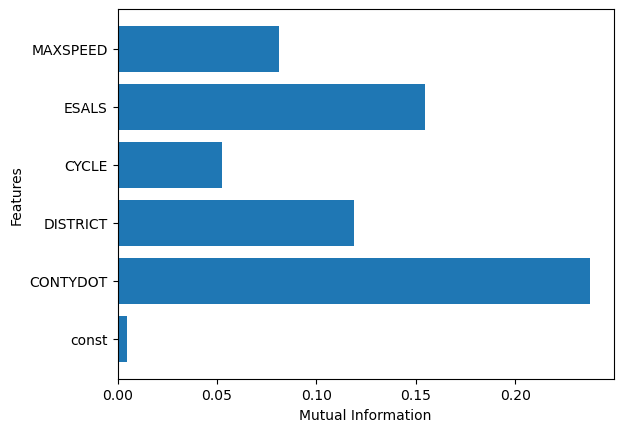

In [33]:
plt.barh(range(len(mi_scores)), mi_scores, tick_label=X.columns)
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.show()

> Correlation Analysis

In [27]:
correlation_matrix = df.corr()
correlation_with_response = correlation_matrix['RATE'].abs().sort_values(ascending=False)
print(correlation_with_response)

RATE        1.000000
MAXSPEED    0.205777
CONTYDOT    0.177225
CYCLE       0.137500
ESALS       0.084453
DISTRICT    0.070056
Name: RATE, dtype: float64


> Feature importance using Random Forest

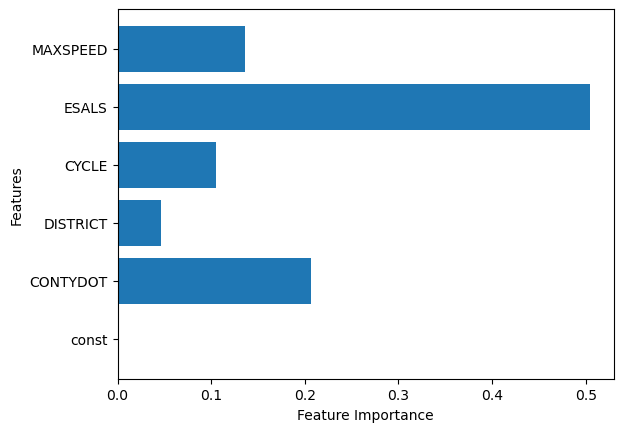

In [30]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X, y)
feature_importance = model.feature_importances_

plt.barh(range(len(feature_importance)), feature_importance, tick_label=X.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

> Recursive Feature Elimination (RFE)

In [32]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=1, step=1)
selector.fit(X, y)
ranking = selector.ranking_

# Get the column names from X
feature_names = X.columns

# Create a dictionary to store variable names and their corresponding ranks
feature_ranking_dict = {feature_names[i]: ranking[i] for i in range(len(feature_names))}

# Sort the dictionary by ranking (from highest to lowest)
sorted_feature_ranking = sorted(feature_ranking_dict.items(), key=lambda x: x[1])

# Print the associated variable in each ranking position
for feature, rank in sorted_feature_ranking:
    print(f"Rank {rank}: {feature}")

Rank 1: CYCLE
Rank 2: DISTRICT
Rank 3: MAXSPEED
Rank 4: CONTYDOT
Rank 5: ESALS
Rank 6: const


> Permutation importance

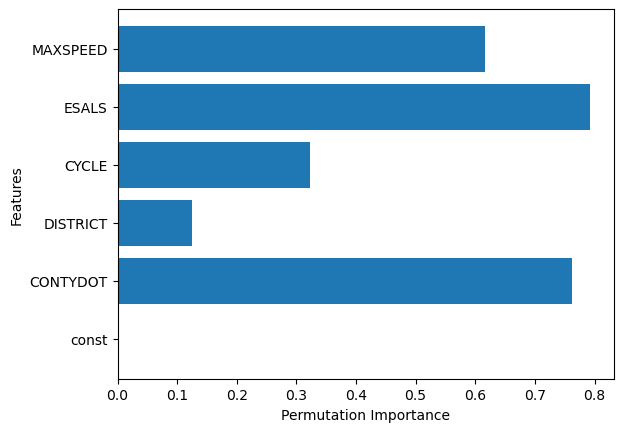

In [35]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model, X, y)

plt.barh(range(len(perm_importance.importances_mean)), perm_importance.importances_mean, tick_label=X.columns)
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.show()

> Information gain

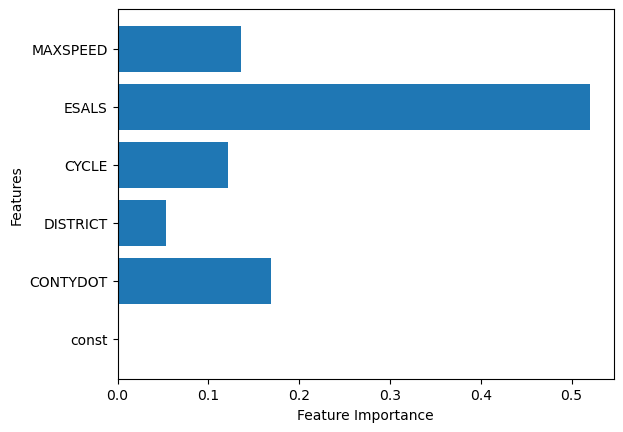

In [37]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
tree.fit(X, y)
feature_importance = tree.feature_importances_

plt.barh(range(len(feature_importance)), feature_importance, tick_label=X.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()


> Principal component analysis

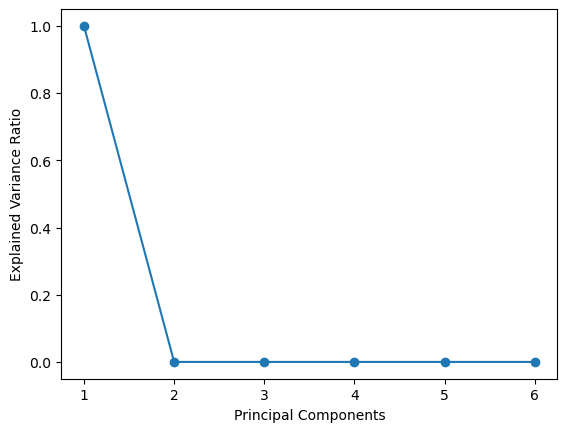

In [38]:
from sklearn.decomposition import PCA

# Assuming you have already defined your feature matrix X

pca = PCA()
pca.fit(X)
explained_variance_ratio = pca.explained_variance_ratio_

plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

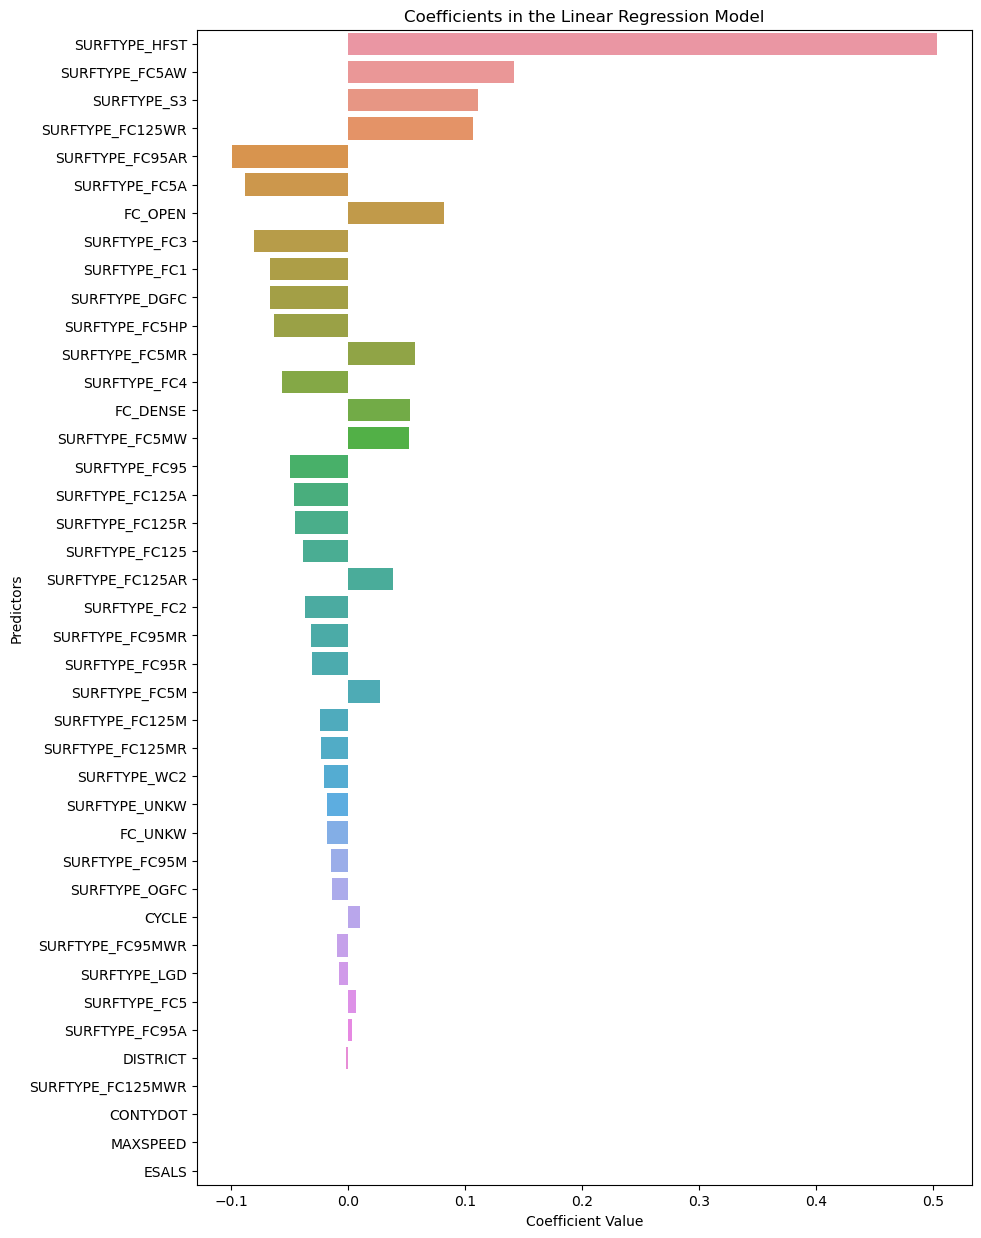

In [40]:
# Load your dataset
# file_path = 'path_to_your_file.csv'  # Replace with your file path
data = pd.read_csv(path)

# Convert categorical variables to dummy variables
data_prepared = pd.get_dummies(data, drop_first=True)

# Separate the target variable 'RATE'
X = data_prepared.drop('RATE', axis=1)
y = data_prepared['RATE']

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the coefficients
coefficients = pd.DataFrame({
    'Variable': X.columns,
    'Coefficient': model.coef_
})

# Rank the variables by the absolute value of their coefficients
coefficients['Absolute Coefficient'] = coefficients['Coefficient'].abs()
coefficients.sort_values(by='Absolute Coefficient', ascending=False, inplace=True)

# Reset index for better readability
coefficients.reset_index(drop=True, inplace=True)

# Plot the coefficients
plt.figure(figsize=(10, 15))
sns.barplot(x='Coefficient', y='Variable', data=coefficients)
plt.title('Coefficients in the Linear Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Predictors')
plt.show()

# Optionally, save the coefficients to a CSV file
# coefficients_file = 'coefficients_ranking.csv'
# coefficients.to_csv(coefficients_file, index=False)


> Running this regression suggests by far the most important factor to focus on is the material of the roadway over anything else!

> Friction course may/may not be useful since it is directly tied to the surface type, so if we consider it there may be 
redundancy **review this logic**

> Now need to find a way to consider the climate data to include as a predictor